In [1]:
import pandas as pd
import numpy as np

In [2]:
# Helper function to import windfarm data
def import_windfarm(filename):
    df = pd.read_csv(filename)
    df['Date'] = pd.to_datetime(df['Date']) # convert dates
    df.drop('Direction (deg)', axis=1, inplace=True) # drop wind direction
    df.rename(columns={'Speed (m/s)':'Loc_wind_speed', 'Energy (kWh)':'True_output'}, inplace=True)
    
    return df

In [3]:
# Import training data for the windfarm
sotavento_train = import_windfarm("data/sotavento_1718.csv")
sotavento_train.head()

,Date,Loc_wind_speed,True_output
0,2017-01-01 01:00:00,4.92,0
1,2017-01-01 02:00:00,4.86,0
2,2017-01-01 03:00:00,5.26,0
3,2017-01-01 04:00:00,5.1,0
4,2017-01-01 05:00:00,5.03,0


In [4]:
# Import testing data for the windfarm
sotavento_test = import_windfarm("data/sotavento_test.csv")
sotavento_test.head()

,Date,Loc_wind_speed,True_output
0,2018-01-10 01:00:00,8.16,9035.64
1,2018-01-10 02:00:00,7.39,7802.97
2,2018-01-10 03:00:00,7.42,7171.58
3,2018-01-10 04:00:00,7.79,6354.43
4,2018-01-10 05:00:00,8.59,7184.31


In [5]:
# Helper function for importing weather data
def weather_data(filename, abbreviation):
    df = pd.read_csv(filename)
    df.rename(columns={df.columns[0]: 'Date' }, inplace = True) # rename first column to "Date"
    df = df[['Date', 'T', 'P', 'U', 'Ff']] # filter dataframe
    df.columns = ['Date', abbreviation+'_temp', abbreviation+'_press', abbreviation+'_hum', abbreviation+'_wind']
    df['Date'] = pd.to_datetime(df['Date']) # convert dates
    df.sort_values(by='Date', inplace=True)
    
    return df

In [6]:
# Import all the weather data
asturias = weather_data("data/weather_asturias.csv", "AST")
compostela = weather_data("data/weather_compostela.csv", "COM")
coruna = weather_data("data/weather_coruna.csv", "COR")
vigo = weather_data("data/weather_vigo.csv", "VIG")

In [7]:
# Create a list of all the cities for merging purposes
cities = [asturias, compostela, coruna, vigo]

In [8]:
# Helper function for merging dataframes
def merge_data(base, cities_list, shift_hours):
    df = base.copy()
    for city in cities:
        df = pd.merge(df, city, how="left", on='Date')
        
    df.drop(df[df['Date'].duplicated()==True].index, inplace=True) #drop all duplicate dates
    
    cols = df.columns.tolist()
    cols = cols[0:2] + cols[3:-1] + cols[2:3] # re-order columns so output is at the end
    df = df[cols]
    df.set_index('Date', inplace=True) # set the data as index
    
    df['Future_output'] = df['True_output'].shift(-shift_hours) # lag the output to predict for the future
    df.replace("-", np.nan, inplace=True) # convert hyphens to NaN
    df.dropna(inplace=True) # drop all NaN's
    df = df.astype(float) # convert numbers to floats
    
    return df

In [9]:
# Set amount of hours that we want to predict in advance
hours = 3

In [10]:
# Make complete training data-set
complete_train = merge_data(sotavento_train, cities, hours)
complete_train.head()

,Loc_wind_speed,AST_temp,AST_press,AST_hum,AST_wind,COM_temp,COM_press,COM_hum,COM_wind,COR_temp,COR_press,COR_hum,COR_wind,VIG_temp,VIG_press,VIG_hum,True_output,Future_output
Date,,,,,,,,,,,,,,,,,,
2017-01-01 01:00:00,4.92,3.9,772.2,89.0,4.0,0.1,773.1,100.0,2.0,4.0,771.9,100.0,2.0,6.0,771.1,87.0,0.0,0.0
2017-01-01 02:00:00,4.86,3.4,771.4,90.0,5.0,-0.5,772.6,100.0,1.0,3.0,771.1,100.0,3.0,5.0,771.1,93.0,0.0,0.0
2017-01-01 03:00:00,5.26,2.9,771.3,90.0,3.0,-1.1,772.5,100.0,1.0,4.0,771.1,100.0,2.0,5.0,770.4,87.0,0.0,0.0
2017-01-01 04:00:00,5.10,2.2,771.1,91.0,3.0,1.1,772.0,100.0,0.0,4.0,770.4,100.0,1.0,4.0,770.4,93.0,0.0,0.0
2017-01-01 05:00:00,5.03,2.3,770.8,88.0,3.0,-1.4,772.0,100.0,0.0,4.0,770.4,100.0,1.0,5.0,769.6,87.0,0.0,0.0


In [11]:
# Make complete testing data-set
complete_test = merge_data(sotavento_test, cities, hours)
complete_test.head()

,Loc_wind_speed,AST_temp,AST_press,AST_hum,AST_wind,COM_temp,COM_press,COM_hum,COM_wind,COR_temp,COR_press,COR_hum,COR_wind,VIG_temp,VIG_press,VIG_hum,True_output,Future_output
Date,,,,,,,,,,,,,,,,,,
2018-01-10 01:00:00,8.16,15.1,769.4,89.0,1.0,12.7,768.1,84.0,1.0,15.0,768.1,82.0,2.0,16.0,765.8,72.0,9035.64,6354.43
2018-01-10 02:00:00,7.39,15.3,769.6,85.0,2.0,12.2,768.4,86.0,3.0,15.0,768.9,77.0,2.0,16.0,765.8,59.0,7802.97,7184.31
2018-01-10 03:00:00,7.42,15.2,770.0,80.0,2.0,12.1,768.6,86.0,2.0,15.0,768.9,82.0,2.0,15.0,765.8,63.0,7171.58,8953.40
2018-01-10 04:00:00,7.79,15.1,770.0,79.0,2.0,12.0,768.7,86.0,2.0,15.0,768.9,77.0,2.0,14.0,765.8,72.0,6354.43,8362.72
2018-01-10 05:00:00,8.59,14.7,769.8,81.0,2.0,12.2,768.3,82.0,2.0,15.0,768.9,77.0,3.0,14.0,765.8,72.0,7184.31,10841.92


In [12]:
from sklearn import preprocessing
import sklearn

In [13]:
# Create testing sets from dataframes
complete_train_shuffled = sklearn.utils.shuffle(complete_train)

X_train = complete_train_shuffled.drop(['True_output', 'Future_output'], axis=1).values
y_train = complete_train_shuffled[['Future_output']].values

X_train = preprocessing.scale(X_train)
y_train = y_train / max(y_train)

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import keras

Using TensorFlow backend.


In [ ]:
# Set up the neural network
EPOCHS = 500

model = Sequential()
model.add(Dense(1024, input_dim=X_train.shape[1], activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="relu"))

optimizer = Adam(learning_rate=1e-5, decay=1e-5/EPOCHS, epsilon=0.1)
early_stopping_monitor = EarlyStopping(monitor="val_loss", patience=5)

In [ ]:
# Compile the model
model.compile(loss="mae", optimizer=optimizer)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_split=0.3, verbose=2, callbacks=[early_stopping_monitor])

In [ ]:
# Obtain loss and val_loss history
loss = history.history["loss"]
val_loss = history.history["val_loss"]

In [15]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

In [ ]:
# Plot loss history
plt.figure(figsize=(10,5))
plt.plot(loss, label="Loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.show()

In [17]:
# Save (and load) the model
#model.save("wind_predict_nn_01dropout_big_first_layer.h5")
model = keras.models.load_model("BEST_wind_predict_nn_01dropout_big_first_layer.h5")

In [18]:
# Create testing sets from dataframes
X_test = complete_test.drop(['True_output', 'Future_output'], axis=1).values
y_test = complete_test[['Future_output']].values

y_scale = max(y_test) # save as scale factor for later

X_test = preprocessing.scale(X_test)
y_test = y_test / y_scale

In [19]:
model.evaluate(X_test, y_test)

2180/2180 [==============================] - 0s 46us/step


0.14782228070447956

In [20]:
y_pred = model.predict(X_test)

In [21]:
# Scale data back
y_true = y_test * y_scale
y_pred_true = y_pred * y_scale

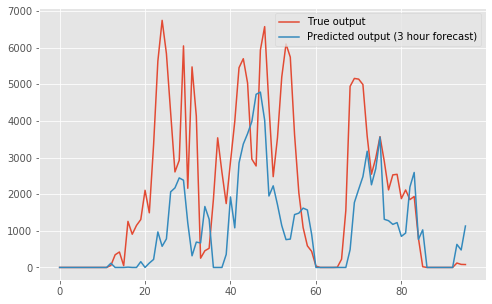

In [22]:
# Plot predictions
plt.figure(figsize=(8,5))
plt.plot(y_true[-96:], label="True output")
plt.plot(y_pred_true[-96:], label="Predicted output (3 hour forecast)")
plt.legend()
plt.show()

In [23]:
# Moving average helper function
def moving_average(data, window_size):
    series = pd.Series(data)
    windows = series.rolling(window_size)
    moving_averages = windows.mean()
    moving_averages_list = moving_averages.tolist()
    without_nans = moving_averages_list[window_size-1:]
    
    return without_nans

In [26]:
# Take moving averages to smoothen curves
window_size = 5

y_true_ma = moving_average(y_true[:, 0], window_size)
y_true_pred_ma = moving_average(y_pred_true[:, 0], window_size)

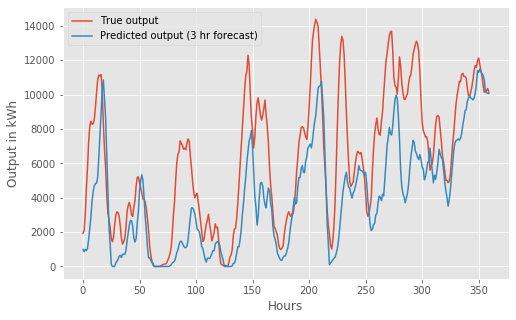

In [31]:
# Plot moving averages
plt.figure(figsize=(8,5))
plt.plot(y_true_ma[-600:-240], label="True output")
plt.plot(y_true_pred_ma[-600:-240], label="Predicted output (3 hr forecast)")
plt.xlabel("Hours")
plt.ylabel("Output in kWh")
plt.legend()
plt.show()